# Generate PyORBIT-readable tomo file to create longitudinal distribution in PyORBIT
- Uses measured tomo file ../../00_Longitudinal_Distribution/C200_001_001_002.dat

This script takes an output from the tomo (.dat format), and runs the file through the executable tomo_vo.intelmp, thus generating a .mat file to be read by a PyORBIT distribution generator (written by CERN BE-ABP-HSI members Hannes Bartosik, Foteini Asvesta, and Haroon Rafique) which generates the longitudinal distribution
based on the measured tomo data.

### This script is based on the work of:
- Simon Albright (BE-RF)
- Andrea Santamaria Garcia (BE-OP)
- Eirini Koukovini-Platia (BE-ABP-HSC)

and is made available by Haroon Rafique (CERN BE-ABP-HSI) as is.

In [1]:
import os
import re
import sys
import subprocess
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt

In [2]:
input_file_name='../../00_Longitudinal_Distribution/C200_001_001_002.dat'
input_file_path=input_file_name

## Run the provided tomo executable using the input file
- subprocess allows us to spawn new processes, connect to their input/output/error pipes, and obtain their return codes.

In [3]:
result = subprocess.Popen(['./tomo_vo.intelmp'], stdin=open(input_file_path, 'r'), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = result.communicate()
out = out.splitlines()

### executable output:
- here we find useful output such as the width of each bin in time and energy

In [4]:
out

[' Start',
 ' plotinfo.data',
 'Number of profiles used in each reconstruction,',
 ' profilecount = 150',
 'Width (in pixels) of each image = length (in bins) of each profile,',
 ' profilelength = 100',
 'Width (in s) of each pixel = width of each profile bin,',
 ' dtbin = 2.5000E-09',
 'Height (in eV) of each pixel,',
 ' dEbin = 1.4344E+05',
 'Number of elementary charges in each image,',
 ' eperimage = 7.187E+11',
 'Position (in pixels) of the reference synchronous point:',
 ' xat0 =  46.037',
 ' yat0 =  50.000',
 'Foot tangent fit results (in bins):',
 ' tangentfootl =   17.420',
 ' tangentfootu =   74.539',
 ' fit xat0 =  46.037',
 'Synchronous phase (in radians):',
 ' phi0(  2) =-0.0044',
 'Horizontal range (in pixels) of the region in phase space of map elements:',
 ' imin(  2) =   2 and imax(  2) =  90',
 ' Tracking from time slice   2 to   3,   0.000% went outside the image width.',
 ' Tracking from time slice   2 to   4,   0.000% went outside the image width.',
 ' Tracking fro

### executable error output:

In [5]:
err

''

### Read the created image file
- reshape from one column to a square

In [6]:
dat = np.loadtxt("image002.data") # This name may be different, please check if it doesnt work

var = (int(np.sqrt(dat.shape[0])), int(np.sqrt(dat.shape[0])))
dat = dat.reshape(var).T

### Shape of data

In [7]:
var

(100, 100)

# Data
- because pyhton outputs a summary we see lots of zeroes as we observe the outer edges of the image

In [8]:
dat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Centre check
- if we look at the centre things are different

In [9]:
mid = var[0]/2
dat[mid, mid]

0.00050528347

In [10]:
print(out[7])
print(out[9])

 dtbin = 2.5000E-09
 dEbin = 1.4344E+05


In [11]:
# formatter for output (out) binsizes
regexp = re.compile("\\d+\\.?\\d*E?[-+]?\\d*")

# Save in units of nanoseconds and mega electron volts
dt = float(regexp.findall(out[7])[0])/1E-9 # ns
dE = float(regexp.findall(out[9])[0])/1E6  # MeV

In [12]:
# make bins
tAxis = np.arange(dat.shape[0])*dt
EAxis = np.arange(dat.shape[0])*dE

# centre on (0,0) - not exact
tAxis -= np.mean(tAxis)
EAxis -= np.mean(EAxis)

## Plot raw data
- note any outliers, filaments etc outside of the separatrix
- These will cause losses or strange dynamics that will reduce the reliability of PyORBIT space charge simulations
- For this specific example we see three `islands', near (-50 ns, -3 MeV), (-70 ns, 0 MeV), and (100 ns, 1 MeV)

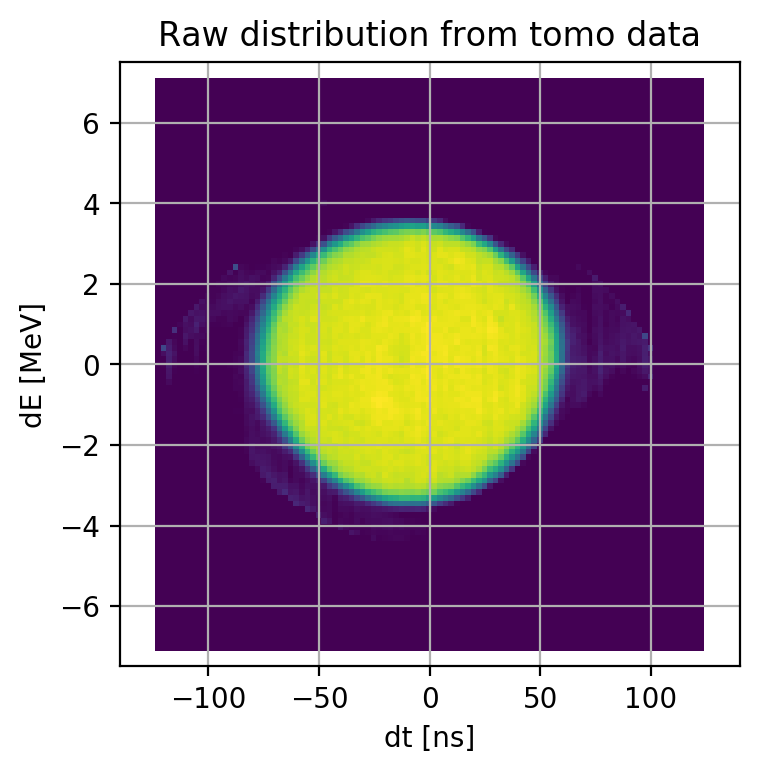

In [13]:
fig, ax = plt.subplots(figsize=(4, 4), dpi= 200, facecolor='w', edgecolor='k')
ax.pcolor(tAxis, EAxis, dat)
ax.set_xlim(-140, 140)
ax.set_ylim(-7.5, 7.5)
ax.set(xlabel='dt [ns]', ylabel='dE [MeV]', title='Raw distribution from tomo data')
ax.grid(True)
plot_name = input_file_name + '_raw.png'
fig.savefig(plot_name, dpi=600)

## Manually shift centre for this example

In [14]:
tAxis += 8	#MD4224 Vertical 1

## Simple filter
- removes pixels if all surrounding pixels are zero
- thus erroneous data points or fragments of binning are removed

In [15]:
filter_level = 5E-5

for x,y in np.ndindex(dat.shape):
	if dat[x,y] < filter_level:					# 1.3 eVs
		dat[x,y] = 0.0	
		
# This filters any pixel where surrounding pixels are 0
# may need to be modified if your phase space isn't a bunch but
# contains some sort of lines / filamentation that is wanted
for x in range (0, dat.shape[0], 1):
	for y in range( 0, dat.shape[1], 1):
		if x == 0 or y == 0 or x == (dat.shape[0]-1) or y == (dat.shape[1]-1) or dat[x,y] == 0.0:
			pass
		else: 
			if dat[x, y-1] == 0.0 and dat[x, y+1] == 0.0:
				print 'outlier removed at [',x, ',' ,y, ']'
				dat[x,y] = 0.0			

outlier removed at [ 24 , 27 ]
outlier removed at [ 25 , 25 ]
outlier removed at [ 27 , 23 ]
outlier removed at [ 47 , 89 ]
outlier removed at [ 48 , 80 ]
outlier removed at [ 52 , 1 ]
outlier removed at [ 52 , 89 ]
outlier removed at [ 54 , 88 ]
outlier removed at [ 55 , 3 ]
outlier removed at [ 58 , 85 ]
outlier removed at [ 66 , 14 ]


## Plot filtered and centred data
- note any outliers, filaments etc outside of the separatrix
- These will cause losses or strange dynamics that will reduce the reliability of PyORBIT space charge simulations
- For this specific example we see three `islands', near (-50 ns, -3 MeV), (-70 ns, 0 MeV), and (100 ns, 1 MeV)

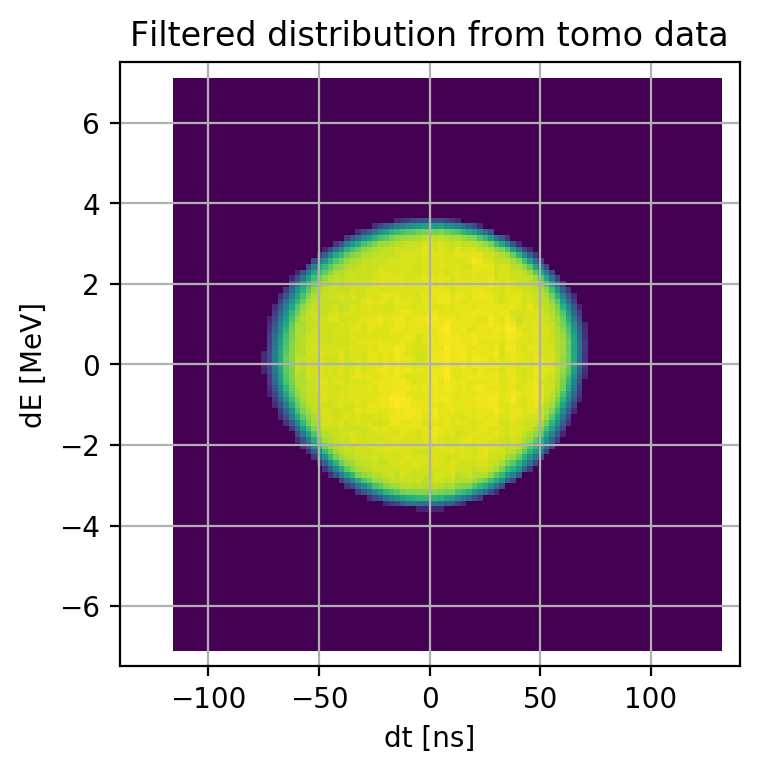

In [16]:
fig, ax = plt.subplots(figsize=(4, 4), dpi= 200, facecolor='w', edgecolor='k')
ax.pcolor(tAxis, EAxis, dat)
ax.set_xlim(-140, 140)
ax.set_ylim(-7.5, 7.5)
ax.set(xlabel='dt [ns]', ylabel='dE [MeV]', title='Filtered distribution from tomo data')
ax.grid(True)
plot_name = input_file_name + '_filtered.png'
fig.savefig(plot_name, dpi=600)

## Save file in text format
- Not used in PyORBIT, only intended to be readable

In [18]:
# Save file for PyORBIT - Format 1 (untested)
thefile = open("PyORBIT_Tomo_file.txt","w+")

# First line: Minimum dt, maximum dt, binsize, bins
thefile.write("%f\t%f\t%f\t%i" % (min(tAxis), max(tAxis), dt, len(tAxis)))

# Second line: Minimum dE, maximum dE, binsize, bins
thefile.write("\n%f\t%f\t%f\t%i" % (min(EAxis), max(EAxis), dE, len(EAxis)))

# Write density as grid
thefile.write("\n")
data = dat.tolist()

for i in range (0, (var[0]-1), 1):
	for j in range (0, (var[1]-1), 1):
		thefile.write("%1.10f\t" % (data[i][j]))
	thefile.write("\n")
	
thefile.close()

## Save file in mat format
- This file is read by PyORBIT to create our longitudinal distribution

In [19]:
data_dict = {'time_nsec': tAxis, 'energy_MeV': EAxis, 'density_array': dat}
savemat('PyORBIT_Tomo_file.mat', data_dict)